# Introduction

We tackle the problem of OCR post processing. In OCR, we map the image form of the document into the text domain. This is done first using an CNN+LSTM+CTC model, in our case based on tesseract. Since this output maps only image to text, we need something on top to validate and correct language semantics.

The idea is to build a language model, that takes the OCRed text and corrects it based on language knowledge. The langauge model could be:
- Char level: the aim is to capture the word morphology. In which case it's like a spelling correction system.
- Word level: the aim is to capture the sentence semnatics. But such systems suffer from the OOV problem.
- Fusion: to capture semantics and morphology language rules. The output has to be at char level, to avoid the OOV. However, the input can be char, word or both.

The fusion model target is to learn:

    p(char | char_context, word_context)

In this workbook we use seq2seq vanilla Keras implementation, adapted from the lstm_seq2seq example on Eng-Fra translation task. The adaptation involves:

- Adapt to spelling correction, on char level
- Pre-train on a noisy, medical sentences
- Fine tune a residual, to correct the mistakes of tesseract 
- Limit the input and output sequence lengths
- Enusre teacher forcing auto regressive model in the decoder
- Limit the padding per batch
- Learning rate schedule
- Bi-directional LSTM Encoder
- Bi-directional GRU Encoder


# Imports

In [56]:
from __future__ import print_function
import tensorflow as tf
import keras.backend as K
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional, Concatenate, GRU
from keras import optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard, LearningRateScheduler
from keras.models import load_model
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# Utility functions

In [2]:
# Limit gpu allocation. allow_growth, or gpu_fraction
def gpu_alloc():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))

In [3]:
gpu_alloc()

In [4]:
def calculate_WER_sent(gt, pred):
    '''
    calculate_WER('calculating wer between two sentences', 'calculate wer between two sentences')
    '''
    gt_words = gt.lower().split(' ')
    pred_words = pred.lower().split(' ')
    d = np.zeros(((len(gt_words) + 1), (len(pred_words) + 1)), dtype=np.uint8)
    # d = d.reshape((len(gt_words)+1, len(pred_words)+1))

    # Initializing error matrix
    for i in range(len(gt_words) + 1):
        for j in range(len(pred_words) + 1):
            if i == 0:
                d[0][j] = j
            elif j == 0:
                d[i][0] = i

    # computation
    for i in range(1, len(gt_words) + 1):
        for j in range(1, len(pred_words) + 1):
            if gt_words[i - 1] == pred_words[j - 1]:
                d[i][j] = d[i - 1][j - 1]
            else:
                substitution = d[i - 1][j - 1] + 1
                insertion = d[i][j - 1] + 1
                deletion = d[i - 1][j] + 1
                d[i][j] = min(substitution, insertion, deletion)
    return d[len(gt_words)][len(pred_words)]

In [5]:
def calculate_WER(gt, pred):
    '''

    :param gt: list of sentences of the ground truth
    :param pred: list of sentences of the predictions
    both lists must have the same length
    :return: accumulated WER
    '''
#    assert len(gt) == len(pred)
    WER = 0
    nb_w = 0
    for i in range(len(gt)):
        #print(gt[i])
        #print(pred[i])
        WER += calculate_WER_sent(gt[i], pred[i])
        nb_w += len(gt[i])

    return WER / nb_w

In [6]:
# Artificial noisy spelling mistakes
def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''
    letters = ['a','b','c','d','e','f','g','h','i','j','k','l','m',
           'n','o','p','q','r','s','t','u','v','w','x','y','z',]
    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform(0, 1, 1)
        # Most characters will be correct since the threshold value is high
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            new_random = np.random.uniform(0, 1, 1)
            # ~33% chance characters will swap locations
            if new_random > 0.67:
                if i == (len(sentence) - 1):
                    # If last character in sentence, it will not be typed
                    continue
                else:
                    # if any other character, swap order with following character
                    noisy_sentence.append(sentence[i + 1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # ~33% chance an extra lower case letter will be added to the sentence
            elif new_random < 0.33:
                random_letter = np.random.choice(letters, 1)[0]
                noisy_sentence.append(random_letter)
                noisy_sentence.append(sentence[i])
            # ~33% chance a character will not be typed
            else:
                pass
        i += 1

    return ''.join(noisy_sentence)

In [7]:
def load_data_with_gt(file_name, num_samples, max_sent_len, min_sent_len, delimiter='\t', gt_index=1, prediction_index=0):
    '''Load data from txt file, with each line has: <TXT><TAB><GT>. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    for row in open(file_name, encoding='utf8'):
        if cnt < num_samples :
            #print(row)
            sents = row.split(delimiter)
            input_text = sents[prediction_index]
            
            target_text = '\t' + sents[gt_index] + '\n'
            if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                cnt += 1
                
                input_texts.append(input_text)
                target_texts.append(target_text)
                gt_texts.append(sents[gt_index])
    return input_texts, target_texts, gt_texts

In [8]:
def load_data_with_noise(file_name, num_samples, noise_threshold, max_sent_len, min_sent_len):
    '''Load data from txt file, with each line has: <TXT>. The GT is just a noisy version of TXT. The  target to the decoder muxt have \t as the start trigger and \n as the stop trigger.'''
    cnt = 0  
    input_texts = []
    gt_texts = []
    target_texts = []
    while cnt < num_samples :
        #for row in open(file_name, encoding='utf8'):
        for row in open(file_name):
            if cnt < num_samples :
                sents = row.split("\t")
                input_text = noise_maker(sents[1], noise_threshold)
                input_text = input_text[:-1]

                target_text = '\t' + sents[1] + '\n'            
                if len(input_text) > min_sent_len and len(input_text) < max_sent_len and len(target_text) > min_sent_len and len(target_text) < max_sent_len:
                    cnt += 1
                    input_texts.append(input_text)
                    target_texts.append(target_text)
                    gt_texts.append(target_text[1:-1])
                    
    return input_texts, target_texts, gt_texts

In [9]:
def build_vocab(all_texts):
    '''Build vocab dictionary to victorize chars into ints'''
    vocab_to_int = {}
    count = 0
    
    for sentence in all_texts:
        for char in sentence:
            if char not in vocab_to_int:
                vocab_to_int[char] = count
                count += 1
    # Add special tokens to vocab_to_int
    codes = ['\t','\n']
    for code in codes:
        if code not in vocab_to_int:
            vocab_to_int[code] = count
            count += 1
    '''''Build inverse translation from int to char'''
    int_to_vocab = {}
    for character, value in vocab_to_int.items():
        int_to_vocab[value] = character
        
    return vocab_to_int, int_to_vocab

In [10]:
def vectorize_data(input_texts, target_texts, max_encoder_seq_length, num_encoder_tokens, vocab_to_int):
    '''Prepares the input text and targets into the proper seq2seq numpy arrays'''
    encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
    decoder_input_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
        dtype='float32')
    decoder_target_data = np.zeros(
        (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
        dtype='float32')

    for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
        for t, char in enumerate(input_text):
            # c0..cn
            encoder_input_data[i, t, vocab_to_int[char]] = 1.
        for t, char in enumerate(target_text):
            # c0'..cm'
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_input_data[i, t, vocab_to_int[char]] = 1.
            if t > 0:
                # decoder_target_data will be ahead by one timestep
                # and will not include the start character.
                decoder_target_data[i, t - 1, vocab_to_int[char]] = 1.
                
    return encoder_input_data, decoder_input_data, decoder_target_data

In [11]:
def decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, vocab_to_int['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = int_to_vocab[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


In [12]:
def build_model(num_encoder_tokens, latent_dim):
    # Define an input sequence and process it.
    encoder_inputs = Input(shape=(None, num_encoder_tokens))
    # TODO: Add Embedding for chars
    #encoder = LSTM(latent_dim, return_state=True) #LSTM
    encoder = Bidirectional(LSTM(latent_dim, return_state=True)) # Bi LSTM
    #encoder = Bidirectional(GRU(latent_dim, return_state=True))# Bi GRU
    #encoder = GRU(latent_dim, return_state=True)# GRU

    #encoder_outputs, state_h, state_c = encoder(encoder_inputs)# LSTM
    encoder_outputs, state_f_h, state_f_c, state_b_h, state_b_c = encoder(encoder_inputs)# Bi LSTM
    #encoder_outputs, state_f, state_b = encoder(encoder_inputs)# Bi GRU

    #state = Concatenate()([state_f, state_b])# Bi GRU
    state_h = Concatenate()([state_f_h, state_b_h])# Bi LSTM
    state_c = Concatenate()([state_f_c, state_b_c])# Bi LSTM

    # We discard `encoder_outputs` and only keep the states.
    encoder_states = [state_h, state_c]# Bi GRU, LSTM, BHi LSTM
    
    #encoder_states = [state]# Bi GRU
    #encoder_states = [state_f_h, state_f_c, state_b_h, state_b_c]

    # Set up the decoder, using `encoder_states` as initial state.
    decoder_inputs = Input(shape=(None, num_decoder_tokens))
    # We set up our decoder to return full output sequences,
    # and to return internal states as well. We don't use the
    # return states in the training model, but we will use them in inference.
    #decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)# LSTM
    decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True)# Bi LSTM
    #decoder_lstm = GRU(latent_dim*2, return_sequences=True, return_state=True)# Bi GRU
    '''
    decoder_outputs, _, _ = Bidirectional(decoder_lstm(decoder_inputs,
                                         initial_state=encoder_states))
    '''

    decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                         initial_state=encoder_states)


    #decoder_outputs, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

    decoder_dense = Dense(num_decoder_tokens, activation='softmax')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Define the model that will turn
    # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    print('encoder-decoder  model:')
    print(model.summary()) 
    print(encoder_states)
    encoder_model = Model(encoder_inputs, encoder_states)

    #decoder_state_input_h = Input(shape=(latent_dim,))# LSTM
    #decoder_state_input_c = Input(shape=(latent_dim,))# LSTM
    decoder_state_input_h = Input(shape=(latent_dim*2,))# Bi LSTM
    decoder_state_input_c = Input(shape=(latent_dim*2,)) # Bi LSTM
    #decoder_state_input = Input(shape=(latent_dim*2,)) # Bi GRU

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    #decoder_states_inputs = [decoder_state_input] # Bi GRU

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    #decoder_outputs, state = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

    decoder_states = [state_h, state_c]
    #decoder_states = [state] # Bi GRU
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return model, encoder_model, decoder_model

# Load data

In [13]:
data_path = '../../dat/'

In [14]:
max_sent_len = 1000000
min_sent_len = -1

## Results on tesseract correction

In [15]:
num_samples = 1000000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

In [16]:
input_texts = input_texts_OCR
target_texts = target_texts_OCR

In [17]:
## Histogram of lenghts
lengths = []
for text in input_texts:
    lengths.append(len(text))
    lengths.append(len(text))

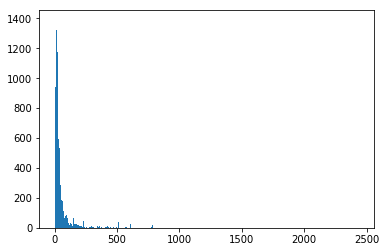

In [18]:
h = plt.hist(lengths, bins=500)

In [19]:
h[0]

array([ 1180.,   940.,  1384.,  1322.,  1174.,   722.,   592.,   536.,
         332.,   286.,   242.,   186.,   180.,   214.,   112.,   154.,
          68.,    82.,    58.,    88.,    70.,    64.,    32.,    30.,
          20.,    26.,    32.,    24.,    58.,    14.,    64.,     6.,
          28.,    16.,    24.,    28.,     8.,    18.,    14.,    18.,
          12.,    24.,    14.,    28.,    14.,     4.,    12.,    44.,
           4.,     6.,     2.,     4.,     6.,     0.,    36.,     0.,
           4.,     4.,     8.,     6.,    14.,     8.,     8.,     8.,
           2.,     0.,     6.,     2.,     2.,     4.,    12.,    14.,
           8.,    12.,     6.,     0.,     4.,     4.,     2.,     0.,
           2.,     0.,     4.,     6.,     0.,     4.,    14.,    26.,
           4.,     0.,     2.,     4.,     4.,     2.,     4.,     2.,
           6.,     0.,     2.,     2.,     2.,     6.,     4.,     2.,
          40.,     4.,     0.,     0.,     2.,     0.,     0.,     0.,
      

In [20]:
h[1]

array([    0.   ,     4.878,     9.756,    14.634,    19.512,    24.39 ,
          29.268,    34.146,    39.024,    43.902,    48.78 ,    53.658,
          58.536,    63.414,    68.292,    73.17 ,    78.048,    82.926,
          87.804,    92.682,    97.56 ,   102.438,   107.316,   112.194,
         117.072,   121.95 ,   126.828,   131.706,   136.584,   141.462,
         146.34 ,   151.218,   156.096,   160.974,   165.852,   170.73 ,
         175.608,   180.486,   185.364,   190.242,   195.12 ,   199.998,
         204.876,   209.754,   214.632,   219.51 ,   224.388,   229.266,
         234.144,   239.022,   243.9  ,   248.778,   253.656,   258.534,
         263.412,   268.29 ,   273.168,   278.046,   282.924,   287.802,
         292.68 ,   297.558,   302.436,   307.314,   312.192,   317.07 ,
         321.948,   326.826,   331.704,   336.582,   341.46 ,   346.338,
         351.216,   356.094,   360.972,   365.85 ,   370.728,   375.606,
         380.484,   385.362,   390.24 ,   395.118, 

In [21]:
max_sent_len =  h[1][np.argmax(h[0])]
min_sent_len = h[1][1]
print('Most probable length = ', max_sent_len)
print('Count of most probable lenght = ', np.max(h[0]))
print('Min length = ', min_sent_len)

Most probable length =  9.756
Count of most probable lenght =  1384.0
Min length =  4.878


In [22]:
max_sent_len =  50#int(np.ceil(max_sent_len))
min_sent_len = 4#int(np.floor(min_sent_len))

In [23]:
print('Most probable length = ', max_sent_len)
print('Min length = ', min_sent_len)

Most probable length =  50
Min length =  4


In [24]:
num_samples = 1000000

tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
input_texts_OCR_tess, target_texts_tess, gt_tess = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

num_samples = 0
OCR_data = os.path.join(data_path, 'output_handwritten.txt')
input_texts_OCR_hand, target_texts_OCR_hand, gt_texts_OCR_hand = load_data_with_gt(OCR_data, num_samples, max_sent_len, min_sent_len, delimiter='|',gt_index=0, prediction_index=1)

In [25]:
#input_texts = input_texts_OCR
#target_texts = target_texts_OCR
input_texts_OCR = input_texts_OCR_tess + input_texts_OCR_hand
target_texts_OCR = target_texts_tess + target_texts_OCR_hand


In [26]:
len(input_texts_OCR)

3579

# Results of pre-training on generic data

In [27]:
'''
num_samples = 0
big_data = os.path.join(data_path, 'big.txt')
threshold = 0.9
input_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)
'''                                                                 

"\nnum_samples = 0\nbig_data = os.path.join(data_path, 'big.txt')\nthreshold = 0.9\ninput_texts_gen, target_texts_gen, gt_gen = load_data_with_noise(file_name=big_data, \n                                                                 num_samples=num_samples, \n                                                                 noise_threshold=threshold, \n                                                                 max_sent_len=max_sent_len, \n                                                                 min_sent_len=min_sent_len)\n"

In [28]:
#input_texts = input_texs_gen
#target_texts = target_texts_gen

# Results on noisy tesseract corrections

In [29]:
num_samples = 10000
tess_correction_data = os.path.join(data_path, 'all_ocr_data_2.txt')
threshold = 0.9
input_texts_noisy_OCR, target_texts_noisy_OCR, gt_noisy_OCR = load_data_with_noise(file_name=tess_correction_data, 
                                                                 num_samples=num_samples, 
                                                                 noise_threshold=threshold, 
                                                                 max_sent_len=max_sent_len, 
                                                                 min_sent_len=min_sent_len)

In [30]:
'''
input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR
'''

'\ninput_texts = input_texts_noisy_OCR\ntarget_texts = target_texts_noisy_OCR\n'

# Results on merge of tesseract correction + generic data

In [31]:
'''
input_texts = input_texts_OCR + input_texts_gen
target_texts = input_texts_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_OCR + input_texts_gen\ntarget_texts = input_texts_OCR + target_texts_gen\n'

# Results noisy tesseract correction + generic data

In [32]:
'''
input_texts = input_texts_noisy_OCR + input_texts_gen
target_texts = input_texts_noisy_OCR + target_texts_gen
'''

'\ninput_texts = input_texts_noisy_OCR + input_texts_gen\ntarget_texts = input_texts_noisy_OCR + target_texts_gen\n'

# Results noisy tesseract noisy + correction data

In [33]:
input_texts = input_texts_noisy_OCR + input_texts_OCR
target_texts = target_texts_noisy_OCR + target_texts_OCR

# Results of pre-training on generic and fine tuning on tesseract correction

In [34]:
# TODO

In [35]:
# Sample data
print(len(input_texts))
for i in range(10):
    print(input_texts[i], '\n', target_texts[i])

13579
Claim Tye: BVz Accident - Accidental Injury 
 	Claim Type: VB Accident - Accidental Injury


Plicdyhorlder/Owcner Information 
 	Policyholder/Owner Information


First Nam:e 
 	First Name:


Midzdle Name/Iniatial: 
 	Middle Name/Initial:


uLast Name: 
 	Last Name:


cScocial Security Number: 
 	Social Security Number:


Bitrh lDate: 
 	Birth Date:


ender: 
 	Gender:


Language Preferrence: 
 	Language Preference:


Addxress Line 1: 
 	Address Line 1:




## Build vocab

In [36]:
all_texts = target_texts + input_texts
vocab_to_int, int_to_vocab = build_vocab(all_texts)
np.savez('vocab', vocab_to_int=vocab_to_int, int_to_vocab=int_to_vocab, max_sent_len=max_sent_len, min_sent_len=min_sent_len )

In [37]:
input_characters = sorted(list(vocab_to_int))
target_characters = sorted(list(vocab_to_int))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [38]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 13579
Number of unique input tokens: 114
Number of unique output tokens: 114
Max sequence length for inputs: 49
Max sequence length for outputs: 49


# Prepare training data

## Train/test split

In [39]:
# Split the data into training and testing sentences
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

## Vectorize data

## Train data

In [40]:
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

## Test data

In [41]:
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)

# Encoder-decoder model

In [42]:

latent_dim = 256  # Latent dimensionality of the encoding space.

In [43]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

encoder-decoder  model:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 114)    0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 512), (None, 759808      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 114)    0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3

# Training

In [44]:
batch_size = 64  # Batch size for training.
epochs = 50  
lr = 0.01

# Learning rate decay

In [45]:
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [46]:
#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]



In [47]:
def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate
lrate = LearningRateScheduler(exp_decay)
#lr = 0

In [48]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)
#lr = 0

In [49]:
#callbacks_list.append(lrate)

In [50]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

Train on 11542 samples, validate on 2037 samples
Epoch 1/50
11542/11542 [==============================] - 99s 9ms/step - loss: 1.1445 - categorical_accuracy: 0.1666 - val_loss: 0.8547 - val_categorical_accuracy: 0.2336

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23359, saving model to best_model.hdf5


/opt/anaconda3/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'concatenate_1/concat:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'concatenate_2/concat:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


Epoch 2/50
11542/11542 [==============================] - 97s 8ms/step - loss: 0.6413 - categorical_accuracy: 0.2928 - val_loss: 0.4881 - val_categorical_accuracy: 0.3370

Epoch 00002: val_categorical_accuracy improved from 0.23359 to 0.33701, saving model to best_model.hdf5
Epoch 3/50
11542/11542 [==============================] - 94s 8ms/step - loss: 0.4082 - categorical_accuracy: 0.3530 - val_loss: 0.3634 - val_categorical_accuracy: 0.3704

Epoch 00003: val_categorical_accuracy improved from 0.33701 to 0.37043, saving model to best_model.hdf5
Epoch 4/50
11542/11542 [==============================] - 95s 8ms/step - loss: 0.3042 - categorical_accuracy: 0.3796 - val_loss: 0.2926 - val_categorical_accuracy: 0.3874

Epoch 00004: val_categorical_accuracy improved from 0.37043 to 0.38740, saving model to best_model.hdf5
Epoch 5/50
11542/11542 [==============================] - 95s 8ms/step - loss: 0.2465 - categorical_accuracy: 0.3946 - val_loss: 0.2577 - val_categorical_accuracy: 0.3964



KeyboardInterrupt: 

In [57]:
model = load_model('best_model.hdf5')

In [ ]:
encoder_model.save('encoder_model.hdf5')
decoder_model.save('decoder_model.hdf5')

In [58]:
# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: Theraqpy: (Recorded:24Jan208) to Reordged
GT sentence: Therapy: (Recorded:24Jan2018) to Recorded

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: Not Coveerd kAmounft
GT sentence: Not Covered Amount

Decoded sentence: Date of Visit/Admission:

-
Input sentence: C. qInformatio nAbout he Patent.
GT sentence: C. Information About the Patient.

Decoded sentence: Country:

-
Input sentence: Country:
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: ORTHOPEDCS
GT sentence: ORTHOPEDICS

Decoded sentence: Other Family Member:

-
Input sentence: FirstC hoice Healt
GT sentence: First Choice Health

Decoded sentence: Fatient DOB:

-
Input sentence: December 6, 2017
GT sentence: December 6, 2017

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Electrnicaully Signed Date:
GT sentence: Electronically Signed Date:

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: IMPRSESIO
GT sentence: IMPRE

-
Input sentence: No muxrmur heard.
GT sentence: No murmur heard.

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Emplaoyee On & Off-Job Acc January 1,f 2017
GT sentence: Employee On & Off-Job Acc January 1, 2017

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: Address

GT sentence: Address:

Decoded sentence: Country:

-
Input sentence: Finger
GT sentence: Finger

Decoded sentence: Fatient DOB:

-
Input sentence: Co-pay
GT sentence: Co-pay

Decoded sentence: Country:

-
Input sentence: (aNme / Relatiosnhipp)(Telephone umber)
GT sentence: (Name / Relationship) (Telephone Number)

Decoded sentence: Country:

-
Input sentence: AWENDING PHYSICIAN STATEMENT (PLEASE. PRINT)
GT sentence: ATTENDING PHYSICIAN STATEMENT (PLEASE PRINT)

Decoded sentence: Country:

-
Input sentence: Tetenone Num r
GT sentence: Telephone Number

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: CURRENT TOTAL VISIT ABLANCE
GT sentence: CURREN

In [ ]:
#WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
#print('WER_spell_correction |TRAIN= ', WER_spell_correction)

In [59]:
# Sample output from test data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)

-
Input sentence: Date(s)/Type(s) of Treatment
GT sentence: Date(s)/Type(s) of Treatment

Decoded sentence: Date of Visit/Admission:

-
Input sentence: 05/09/1980
GT sentence: 05/09/1980

Decoded sentence: Country:

-
Input sentence: PAY/ADJ
GT sentence: PAY/ADJ

Decoded sentence: Patient Name:

-
Input sentence: ThoracicS tarain
GT sentence: Thoracic Strain

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: Pﬁnreo Name _ ocia ecuri y um er
GT sentence: Printed Name Social Security Number

Decoded sentence: Patient Name:

-
Input sentence: Providen'Facility: ProMedicn Tole do Hospital
GT sentence: Provider/Facility: ProMedica Toledo Hospital

Decoded sentence: Patient Name:

-
Input sentence: Down East rOthopeidcs xSports Medicine
GT sentence: Down East Orthopedics Sports Medicine

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Counttry:
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: Avddress Lin e2: 
GT sentence: Address

-
Input sentence: COMPARISON: None.
GT sentence: COMPARISON: None.

Decoded sentence: Country:

-
Input sentence: Total Monthly Premium:
GT sentence: Total Monthly Premium:

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: Phyiscian Siganture
GT sentence: Physician Signature

Decoded sentence: Patient Name:

-
Input sentence: Expected Delivery Dene: (mmrrinim tmrnin diyy)
GT sentence: Expected Delivery Date: (mm/dd/yy)

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: Today’s tDate:
GT sentence: Today’s Date:

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: PARAMOUNT PAID
GT sentence: PARAMOUNT PAID

Decoded sentence: Patient Name:

-
Input sentence: Totkal onty Premium:
GT sentence: Total Monthly Premium:

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: Hisory of Present Illness:
GT sentence: History of Present Illness:

Decoded sentence: Hospital Name

-
Input senten

-
Input sentence: 90 Days
GT sentence: 90 Days

Decoded sentence: Date of Visit/Admission:

-
Input sentence: DAKOTAARDOLOGY
GT sentence: DAKOTA RADIOLOGY

Decoded sentence: Date of Visit/Admission:

-
Input sentence: ENCOUNTER FOR WlTH
GT sentence: ENCOUNTER FOR WITH

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: Patienyt
GT sentence: Patient

Decoded sentence: Patient Name:

-
Input sentence: Marshfield Cplinic
GT sentence: Marshfield Clinic

Decoded sentence: Medical Provider Roles: Treating

-
Input sentence: Claim Event Information
GT sentence: Claim Event Information

Decoded sentence: Country:

-
Input sentence: Potsal Code:
GT sentence: Postal Code:

Decoded sentence: Patient Name:

-
Input sentence: Isn: Mlainecare
GT sentence: Ins: Mainecare

Decoded sentence: Insured Coverage Type Coverage Effective Date

-
Input sentence: Author: tSouha Hakim, MD
GT sentence: Author: Souha Hakim, MD

Decoded sentence: Country:

-
Input sentence: Country:
GT 

-
Input sentence: ELECTORNICALLY SIGNED BYm
GT sentence: ELECTRONICALLY SIGNED BY:

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: Imgaing eport: Exam: tMRI Low Ext JT W/O Rt
GT sentence: Imaging Report: Exam: MRI Low Ext JT W/O Rt

Decoded sentence: Insured Coverage Type Coverage Effective Date

-
Input sentence: aDte qof First Visit:
GT sentence: Date of First Visit:

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Notes #
GT sentence: Notes #

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Polyic Number:
GT sentence: Policy Number:

Decoded sentence: Patient Name:

-
Input sentence: Irmatienthutpatient Indicator: Outpatient
GT sentence: Inpatient/Outpatient Indicator: Outpatient

Decoded sentence: Insured Coverage Type Coverage Effective Date

-
Input sentence: qEarnings Moxde: nMonthly
GT sentence: Earnings Mode: Monthly

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: Cmsmr Sweetnfomatwni
GT

-
Input sentence: DICTATING DATE/TIME:
GT sentence: DICTATING DATE/TIME:

Decoded sentence: Date of Visit/Admission:

-
Input sentence: A P P O I N T M E N T S
GT sentence: A P P O I N T M E N T S

Decoded sentence: Country:

-
Input sentence: Total mEployeze WeklyPayroll Deductionb:
GT sentence: Total Employee Weekly Payroll Deduction:

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: FINDINGS:
GT sentence: FINDINGS:

Decoded sentence: Fatient DOB:

-
Input sentence: Knee Exam
GT sentence: Knee Exam

Decoded sentence: Date of Visit/Admission:

-
Input sentence: aPge 3
GT sentence: Page 3

Decoded sentence: Country:

-
Input sentence: Employer aNme
GT sentence: Employer Name

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: Preferred language is English.
GT sentence: Preferred language is English.

Decoded sentence: Patient Name:

-
Input sentence: Home per day
GT sentence: Hours per day

Decoded sentence: Hospital Name

-
Inpu

-
Input sentence: If Ya, name of second Employer?
GT sentence: If Yes, name of second Employer?

Decoded sentence: Insured Coverage Type Coverage Effective Date

-
Input sentence: . O . ACCIDENT CLAIM FORM 
GT sentence: ACCIDENT CLAIM FORM

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Gender

GT sentence: Gender:

Decoded sentence: Country:

-
Input sentence: Individual iDsabilbity Policy #
GT sentence: Individual Disability Policy #

Decoded sentence: Insured Coverage Type Coverage Effective Date

-
Input sentence: Date ofD ischarge
GT sentence: Date of Discharge:

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Patient ID

GT sentence: Patient ID:

Decoded sentence: Patient Name:

-
Input sentence: Mediucal Provder Seicalty: EMS
GT sentence: Medical Provider Specialty: EMS

Decoded sentence: Medical Provider Roles: Treating

-
Input sentence: Ciotmtry.
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: Surgery Date:
GT sentence: Surger

-
Input sentence: Ttoal hours work:
GT sentence: Total hours work:

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: Grokubp Policy #
GT sentence: Group Policy #:

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: eMdical Problems:
GT sentence: Medical Problems:

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: As neeuded
GT sentence: As needed

Decoded sentence: Country:

-
Input sentence: http://192.168.101.5
GT sentence: http://192.168.110.5

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: Psychiatric: no psycihatric symptoms.
GT sentence: Psychiatric: no psychiatric symptoms.

Decoded sentence: Patient Name:

-
Input sentence: Disussion/Sucmrnayr
GT sentence: Discussion/Sumrnary

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Tota Monjthly wPvemium:
GT sentence: Total Monthly Premium:

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input 

-
Input sentence: No wDue
GT sentence: Now Due

Decoded sentence: Date of Visit/Admission:

-
Input sentence: ALlLOWED AMOUNT
GT sentence: ALLOWED AMOUNT

Decoded sentence: Country:

-
Input sentence: Choice.p
GT sentence: Choice.

Decoded sentence: Country:

-
Input sentence: Amount Insurance Amount Patient 
GT sentence: Amount Insurance Amount Patient

Decoded sentence: Country:

-
Input sentence: DOB :
GT sentence: DOB :

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Yes No
GT sentence: Yes No

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Emloyee mayu es Righthan or:
GT sentence: Employee may use Right hand for:

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: iVsi tType: Post-O

GT sentence: Visit Type: Post-Op

Decoded sentence: Date of Visit/Admission:

-
Input sentence: PRACTITIONER
GT sentence: PRACTITIONER

Decoded sentence: Patient Name:

-
Input sentence: 3) Zithromax (azithromycin) (moderate)
GT sentence: 3) Zi

-
Input sentence: CLINcICAL INDjICATvION: sTram,a painf.
GT sentence: CLINICAL INDICATION: Trauma, pain.

Decoded sentence: Country:

-
Input sentence: Policyohlder/Owrner Inqformation
GT sentence: Policyholder/Owner Information

Decoded sentence: Patient Name:

-
Input sentence: Total Monthly Premium:
GT sentence: Total Monthly Premium:

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: CI Short Term Disabiiétv
GT sentence: Short Term Disability 

Decoded sentence: Country:

-
Input sentence: Dmate f Birth (mm/dd/yy)
GT sentence: Date of Birth (mm/dd/yy)

Decoded sentence: Date of Visit/Admission:

-
Input sentence: EMERGENCY MEIDCAL ASSOCIATSE
GT sentence: EMERGENCY MEDICAL ASSOCIATES

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: (No tfor FMLA Requests)
GT sentence: (Not for FMLA Requests)

Decoded sentence: Country:

-
Input sentence: DPEHATIVEIPHOCEDUFIE NOTE
GT sentence: OPERATIVE/PROCEDURE NOTE

Decoded sentence: Date 

-
Input sentence: Electronically Signed 02/28/2018
GT sentence: Electronically Signed 02/28/2018

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: DESCRIPTION OF SERVICE
GT sentence: DESCRIPTION OF SERVICE

Decoded sentence: Date of Visit/Admission:

-
Input sentence: NewYork-Presbytiran Weill Cornell Megdicine 
GT sentence: NewYork-Presbyterian Weill Cornell Medicine 

Decoded sentence: Date of Visit/Admission:

-
Input sentence: . i . ACCIDENT CLAIM FORM
GT sentence: ACCIDENT CLAIM FORM

Decoded sentence: Date of Visit/Admission:

-
Input sentence: U n U m‘
GT sentence: unum

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Phone:
GT sentence: Phone:

Decoded sentence: Patient Name:

-
Input sentence: mail Address:
GT sentence: Email Address:

Decoded sentence: Country:

-
Input sentence: Total Paymne Amuont
GT sentence: Total Payment Amount

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: Printed Name
GT senten

-
Input sentence: SEEN SH"?
GT sentence: SUN CITY

Decoded sentence: State/Province:

-
Input sentence: patient:
GT sentence: Patient :

Decoded sentence: Country:

-
Input sentence: Medicl Specaily
GT sentence: Medical Specialty

Decoded sentence: Medical Provider Roles: Treating

-
Input sentence: Surery Inxformation
GT sentence: Surgery Information

Decoded sentence: State/Province:

-
Input sentence: nEmplyoeC ovearge: Ye
GT sentence: Employer Coverage: Yes

Decoded sentence: Date of Visit/Admission:

-
Input sentence: r1) D omf Pain i Right Knee (ICD-719.46)
GT sentence: 1) Dx of Pain in Right Knee (ICD-719.46)

Decoded sentence: Patient Name:

-
Input sentence: Policyholde Owner Informaiton
GT sentence: Policyholder: Owner Information

Decoded sentence: Patient Name:

-
Input sentence: DX:x S82.224A
GT sentence: DX: S82.224A

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Page 3 of 3
GT sentence: Page 3 of 3

Decoded sentence: Patient Name:

-
Input sentence: 28789

-
Input sentence: CIRCLEq mOE
GT sentence: CIRCLE ONE

Decoded sentence: Country:

-
Input sentence: Twisct (wrist)
GT sentence: Twist (wrist)

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: Absence ned time -
GT sentence: Absence end time -

Decoded sentence: Country:

-
Input sentence: Clib stairs/stepsl/adders
GT sentence: Climb stairs/steps/ladders

Decoded sentence: Country:

-
Input sentence: Total rMonthxly Premfium
GT sentence: Total Monthly Premium:

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: MRN :DOB Sexh:
GT sentence: MRN: DOB Sex:

Decoded sentence: Medical Provider Roles: Treating

-
Input sentence: Procedure Decsription
GT sentence: Procedure Description

Decoded sentence: Patient Name:

-
Input sentence: SURGEON: Jjohcn J.l Lain, M.D.
GT sentence: SURGEON: John J. Larkin, M.D.

Decoded sentence: State/Province:

-
Input sentence: BMI: 81.97
GT sentence: BMI: 18.97

Decoded sentence: Total Monthly Premium:


-
Input sentence: Date Hospitalized (mm/dd/yy):
GT sentence: Date Hospitalized (mm/dd/yy):

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Lungs:
GT sentence: Lungs:

Decoded sentence: Country:

-
Input sentence: Electroniic Submisson
GT sentence: Electronic Submission

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: Page5 of 5
GT sentence: Page 5 of 5

Decoded sentence: Patient Name:

-
Input sentence: Revised
GT sentence: Revised

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Forwarding Service Requested
GT sentence: Forwarding Service Requested

Decoded sentence: Fatient DOB:

-
Input sentence: SHORT TERM DIABILITYC LAIM OFMR
GT sentence: SHORT TERM DISABILITY CLAIM FORM

Decoded sentence: State/Province:

-
Input sentence: (Not for FMuLA Requests)
GT sentence: (Not for FMLA Requests)

Decoded sentence: Country:

-
Input sentence: Keybonld wulk .
GT sentence: Keyboard work

Decoded sentence: Date of Visit/Admission:

-
In

-
Input sentence: The Beneﬁts Center
GT sentence: The Benefits Center

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: Electron [1: S u Innis sion
GT sentence: Electronic: Submission

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: 99024 Post-Op mo (oer-99024)
GT sentence: 99024 Post-Op N/C (CPT-99024)

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Gender:
GT sentence: Gender:

Decoded sentence: Country:

-
Input sentence: Spouse Wellness Benefit July 1, 2017
GT sentence: Spouse Wellness Benefit July 1, 2017

Decoded sentence: State/Province:

-
Input sentence: Generarl
GT sentence: General

Decoded sentence: Country:

-
Input sentence: dditioan ljCommts / Inpsturcitons:
GT sentence: Additional Comments / Instructions:

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Past Medical History:
GT sentence: Past Medical History:

Decoded sentence: Patient Name:

-
Input sentence: If yes ,as of what dat

-
Input sentence: New&  mIprovezd Onlen Experience
GT sentence: New & Improved Online Experience

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Gender:
GT sentence: Gender:

Decoded sentence: Country:

-
Input sentence: CL-1023-ATHx(6/31)
GT sentence: CL-1023-AUTH (06/13)

Decoded sentence: Country:

-
Input sentence: : M.3., RA.
GT sentence: Heydemann M.D., P.A.

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: Lastay wrkepd -
GT sentence: Last day worked -

Decoded sentence: Country:

-
Input sentence: Postal Code:
GT sentence: Postal Code:

Decoded sentence: Patient Name:

-
Input sentence: Employment Information
GT sentence: Employment Information

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: Seen By: Vijay Patel, D
GT sentence: Seen By: Vijay Patel, MD

Decoded sentence: State/Province:

-
Input sentence: EE Name:
GT sentence: EE Name:

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Inpu

-
Input sentence: Country.
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: Printced NaeSocila ecurity Number
GT sentence: Printed Name Social Security Number

Decoded sentence: Patient Name:

-
Input sentence: DiagnosisC kode: knee injury
GT sentence: Diagnosis Code: knee injury

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Firsut hoic Helath
GT sentence: First Choice Health

Decoded sentence: Fatient DOB:

-
Input sentence: SURGEON: ASrN HOLM, M.D. 
GT sentence: SURGEON: JASON HOLM, M.D. 

Decoded sentence: State/Province:

-
Input sentence: Heart Rate: 64
GT sentence: Heart Rate: 64

Decoded sentence: Hospital Name

-
Input sentence: TIER 2 Individual MOOP Max
GT sentence: TIER 2 Individual MOOP Max

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: UCR/No-Par Adjustment
GT sentence: UCR/Non-Par Adjustment

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Always 610t0%
GT sentence: Always 67-100%

Decoded 

-
Input sentence: Acident Daute:
GT sentence: Accident Date:

Decoded sentence: Country:

-
Input sentence: Employee Wellness Benefit July 1, 2017
GT sentence: Employee Wellness Benefit July 1, 2017

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: Employee On& Of-fJob cc Jnuary t1, 2017
GT sentence: Employee On & Off-Job Acc January 1, 2017

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: aFx Numbr
GT sentence: Fax Number 

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Accident Work Relate:d No
GT sentence: Accident Work Related: No

Decoded sentence: Country:

-
Input sentence: Employee ID Type: Employee ID
GT sentence: Employee ID Type: Employee ID

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: Lahst Nmae
GT sentence: Last Name:

Decoded sentence: Country:

-
Input sentence: PAGE 1 of 1m
GT sentence: PAGE 1 of 1

Decoded sentence: Patient Name:

-
Input sentence: Social Secu

-
Input sentence: Chief Complaint
GT sentence: Chief Complaint

Decoded sentence: Country:

-
Input sentence: Patent Portion
GT sentence: Patient Portion

Decoded sentence: Patient Name:

-
Input sentence: Totals For Claim
GT sentence: Totals For Claim

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: Op Notes
GT sentence: Op Notes

Decoded sentence: Other Family Member:

-
Input sentence: First Choic eHeatlh
GT sentence: First Choice Health

Decoded sentence: Fatient DOB:

-
Input sentence: Patient ID
GT sentence: Patient ID

Decoded sentence: Patient Name:

-
Input sentence: Individua lSummary
GT sentence: Individual Summary

Decoded sentence: Insured Coverage Type Coverage Effective Date

-
Input sentence: SocialSecurity Numbre:
GT sentence: Social Security Number:

Decoded sentence: State/Province:

-
Input sentence: Surgery - no
GT sentence: Surgery - no

Decoded sentence: State/Province:

-
Input sentence: Is your accident/illnvess work erltd - yes
GT

-
Input sentence: Encountetr Datye:
GT sentence: Encounter Date:

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: uGarantohr Account(for Hosptal Account )
GT sentence: Guarantor Account (for Hospital Account )

Decoded sentence: Date of Visit/Admission:

-
Input sentence: The Beneﬁts Center
GT sentence: The Benefits Center

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: UMR FISEeR I BIyLLED ON
GT sentence: UMR FISERV WI BILLED ON

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Confirmation of oCpvrazge
GT sentence: Confirmation of Coverage

Decoded sentence: Country:

-
Input sentence: Social Security Numbe

GT sentence: Social Security Number

Decoded sentence: State/Province:

-
Input sentence: Esmpxloyer Nme:
GT sentence: Employer Name:

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: altiltliigélés
GT sentence: TWIN CITIES ORTHOPEDICS

Decoded sentence: Date of Visit/Admissio

-
Input sentence: Depenent Iznformation
GT sentence: Dependent Information

Decoded sentence: Date of Visit/Admission:

-
Input sentence: DEPRATMENT FAYETTEVILLE
GT sentence: DEPARTMENT FAYETTEVILLE

Decoded sentence: Date of Visit/Admission:

-
Input sentence: ACCDEN TCLMI ORM 
GT sentence: ACCIDENT CLAIM FORM 

Decoded sentence: Country:

-
Input sentence: (Name (Telephoqne Nuwmbxr

GT sentence: (Name) (Telephone Number)

Decoded sentence: Country:

-
Input sentence: Clairn Ewvent Identifeir: 2677453
GT sentence: Clairn Event Identifier: 2677453

Decoded sentence: Country:

-
Input sentence: Account #:
GT sentence: Account #:

Decoded sentence: Country:

-
Input sentence: Diagnosis Codec I(CD)
GT sentence: Diagnosis Code (ICD)

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Therapy: 21Jan2018 to Recorded
GT sentence: Therapy: 21Jan2018 to Recorded

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: dpept phone:
GT sentence: dept phone:

Decod

-
Input sentence: FIRST NAME:
GT sentence: FIRST NAME:

Decoded sentence: Fatient DOB:

-
Input sentence: Claim Evnet Inforaton
GT sentence: Claim Event Information

Decoded sentence: Country:

-
Input sentence: iHstoyr of Pcresent Illness
GT sentence: History of Present Illness

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Gepnder:
GT sentence: Gender:

Decoded sentence: Country:

-
Input sentence: TbIER 2 Inidvidual Deductibel
GT sentence: TIER 2 Individual Deductible

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: a Family history of other condition (284.89)
GT sentence: • Family history of other condition (Z84.89)

Decoded sentence: Date of Visit/Admission:

-
Input sentence: See tatement Details ovn Back
GT sentence: See Statement Details on Back

Decoded sentence: State/Province:

-
Input sentence: Employer N atne:
GT sentence: Employer Name:

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: . I I ACCID

-
Input sentence: Patint ID:
GT sentence: Patient ID:

Decoded sentence: Patient Name:

-
Input sentence: kFaor:Knee nijury; Otrdeedr Bny:Feivr,y Davwd;
GT sentence: For:Knee injury; Ordered By:Feivor, David;

Decoded sentence: Date of Visit/Admission:

-
Input sentence: CETIFICATE#
GT sentence: CERTIFICATE#

Decoded sentence: Country:

-
Input sentence: Addres sLine 1:
GT sentence: Address Line 1:

Decoded sentence: Country:

-
Input sentence: PROVDER JEREMY O. yTATsTION, MD
GT sentence: PROVIDER JEREMY O. STATTION, MD

Decoded sentence: Patient Name:

-
Input sentence: Emergency
GT sentence: Emergency

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: mlpoyment Informatin
GT sentence: Employment Information

Decoded sentence: Country:

-
Input sentence: You pain becomes more severe.
GT sentence: ● You pain becomes more severe.

Decoded sentence: Date of Visit/Admission:

-
Input sentence: City:
GT sentence: City:

Decoded sentence: Country:

-
Input sente

-
Input sentence: Integmuentay Negative Rash.
GT sentence: Integumentary Negative Rash.

Decoded sentence: Insured Coverage Type Coverage Effective Date

-
Input sentence: Employment History Status jRetired Restrictinos
GT sentence: Employment History Status Retired Restrictions

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: cAct Type Persosnal/Family
GT sentence: Acct Type Personal/Family

Decoded sentence: Country:

-
Input sentence: Gender
GT sentence: Gender:

Decoded sentence: Country:

-
Input sentence: Electronically Sigend by:
GT sentence: Electronically Signed by:

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: CL-1023 (0/6j13)
GT sentence: CL-1023 (06/13)

Decoded sentence: Country:

-
Input sentence: Physician Signature X
GT sentence: Physician Signature X

Decoded sentence: Patient Name:

-
Input sentence: 1. ACL tear.
GT sentence: 1. ACL tear.

Decoded sentence: Insured Coverage Type Coverage Effective Date



-
Input sentence: Region
GT sentence: Region

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Addess Line :1
GT sentence: Address Line 1:

Decoded sentence: Country:

-
Input sentence: Country:
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: _ Military Qualifying Exigency
GT sentence: # 7 Military Qualifying Exigency

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: • MPV - 9.0 Rbange: 7v.4-10.4 - fL
GT sentence: • MPV - 9.0 Range: 7.4-10.4 - fL

Decoded sentence: Insured Coverage Type Coverage Effective Date

-
Input sentence: Date of Birth [mmrddiyﬁ
GT sentence: Date of Birth (mm/dd/yy)

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Musculoskeletal -
GT sentence: Musculoskeletal -

Decoded sentence: Medical Provider Roles: Treating

-
Input sentence: 3.lvA"i tON Oi EitrNt: i5 l its
GT sentence: EXPLANATION OF BENEFITS

Decoded sentence: Country:

-
Input sentence: JacobS .
GT sentence: Jacob S.

Decoded s

-
Input sentence: Report Right wivs.
GT sentence: Report Right wrist.

Decoded sentence: Date of Visit/Admission:

-
Input sentence: ● our legsf eel wea
GT sentence: ● Your legs feel weak.

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: Marshfield Clinic-Phillips Center
GT sentence: Marshfield Clinic-Phillips Center

Decoded sentence: Medical Provider Roles: Treating

-
Input sentence: Did you advice the patent dto stop working?
GT sentence: Did you advice the patient to stop working?

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Cofuntry: 
GT sentence: Country: 

Decoded sentence: Country:

-
Input sentence: pCountry:
GT sentence: Country:

Decoded sentence: Country:

-
Input sentence: Original Print Date:
GT sentence: Original Print Date:

Decoded sentence: Other Family Member:

-
Input sentence: EE Name:
GT sentence: EE Name:

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: Country.
GT sentence: Country:


-
Input sentence: Sposue On & Off-Job Acc wApri l1, 2015
GT sentence: Spouse On & Off-Job Acc April 1, 2015

Decoded sentence: State/Province:

-
Input sentence:  •GLUCOE - 85 Reange: 60-105 - m/gdL
GT sentence: • GLUCOSE - 85 Range: 60-105 - mg/dL

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Weight: 270 lb
GT sentence: Weight: 270 lb

Decoded sentence: Fatient DOB:

-
Input sentence: www.mydocbill.comlsdr1
GT sentence: @ www.mydocbill.com/sdr1

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Totarl Mnthly Premcium:
GT sentence: Total Monthly Premium:

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: B ACalculated: 2.3
GT sentence: BSA Calculated: 2.33

Decoded sentence: Total Monthly Premium:

-
Input sentence: Language Preference ﬂ English Elm Spanish
GT sentence: Language Preference English Spanish

Decoded sentence: Country:

-
Input sentence: Provider: Jason Holm MD.
GT sentence: Provider: Jason Holm M.D.

Decoded senten

-
Input sentence: Explanation ot‘Gap in Time: no
GT sentence: Explanation of Gap in Time: no

Decoded sentence: Employee Wellness Benefit January 1, 2018

-
Input sentence: STATEMENT
GT sentence: STATEMENT

Decoded sentence: State/Province:

-
Input sentence: Z78891 ?
GT sentence: Z87891 ?

Decoded sentence: Date of Visit/Admission:

-
Input sentence: G. Tax colnsideratons
GT sentence: G. Tax considerations

Decoded sentence: Country:

-
Input sentence: Fyirst Choice Health
GT sentence: First Choice Health

Decoded sentence: Fatient DOB:

-
Input sentence: Medical Provider Information - osptialigzastion
GT sentence: Medical Provider Information - Hospitalization

Decoded sentence: Medical Provider Roles: Treating

-
Input sentence: Name of Department:
GT sentence: Name of Department:

Decoded sentence: Date of Visit/Admission:

-
Input sentence: This Plan:
GT sentence: This Plan:

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: Total Employee Bi—Weekly Pay

-
Input sentence: Type of Execrkise: ufeld hockey,c asrdio
GT sentence: Type of Exercise: field hockey, cardio

Decoded sentence: Total Employee Weekly Payroll Deduction:

-
Input sentence: Spouse Infomratio
GT sentence: Spouse Information

Decoded sentence: State/Province:

-
Input sentence: Date ofNeXt Visit;
GT sentence: Date of Next Visit:

Decoded sentence: Date of Visit/Admission:

-
Input sentence: Instyrumetq
GT sentence: Instrument

Decoded sentence: Insured Coverage Type Coverage Effective Date

-
Input sentence: Outof Network
GT sentence: Out of Network

Decoded sentence: Other Family Member:

-
Input sentence: ATTEnDIN GPHYSICIAN SATMEENT
GT sentence: ATTENDING PHYSICIAN STATEMENT

Decoded sentence: Country:

-
Input sentence: Aqua] Dgiivqry Dal; (mwudiyy):
GT sentence: Actual Delivery Date (mm/dd/yy):

Decoded sentence: Country:

-
Input sentence: Date of Nexwt Visit (mm/dd/yy)
GT sentence: Date of Next Visit (mm/dd/yy)

Decoded sentence: Date of Visit/Admission:

-
Input 

In [53]:
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_spell_correction |TEST=  0.166027839419


In [54]:
WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)

WER_OCR |TEST=  0.093134288212


# Test on separate tesseract corrected file

In [ ]:
num_samples = 10000
tess_correction_data = os.path.join(data_path, 'new_trained_data.txt')
input_texts_OCR, target_texts_OCR, gt_OCR = load_data_with_gt(tess_correction_data, num_samples, max_sent_len, min_sent_len)

input_texts = input_texts_OCR
target_texts = target_texts_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

# Sample output from train data
decoded_sentences = []
target_texts_ =  []
for seq_index in range(len(input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = encoder_input_data[seq_index: seq_index + 1]
    
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, input_texts)
print('WER_OCR |TEST= ', WER_OCR)

# Domain transfer from noisy spelling mistakes to OCR corrections

In [ ]:
model, encoder_model, decoder_model = build_model(latent_dim=latent_dim, num_encoder_tokens=num_encoder_tokens)

## Pre-train on noisy spelling mistakes

In [ ]:

input_texts = input_texts_noisy_OCR
target_texts = target_texts_noisy_OCR

encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)

batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.01

#filepath="weights-improvement-{epoch:02d}-{val_categorical_accuracy:.2f}.hdf5"
filepath="best_model_transfer.hdf5" # Save only the best model for inference step, as saving the epoch and metric might confuse the inference function which model to use
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks_list = [checkpoint, tbCallBack]
#callbacks_list = [checkpoint, tbCallBack, lrate]

#model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          #validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          validation_split=0.2,
          shuffle=True)

## Fine tune on OCR correction data

In [ ]:

input_texts = input_texts_OCR
target_texts = target_texts_OCR

# Keep test data from the corrected OCR, as this what we care about
input_texts, test_input_texts, target_texts, test_target_texts  = train_test_split(input_texts, target_texts, test_size = 0.15, random_state = 42)

# Vectorize train data
encoder_input_data, decoder_input_data, decoder_target_data = vectorize_data(input_texts=input_texts,
                                                                             target_texts=target_texts, 
                                                                             max_encoder_seq_length=max_encoder_seq_length, 
                                                                             num_encoder_tokens=num_encoder_tokens, 
                                                                             vocab_to_int=vocab_to_int)
# Vectorize test data
test_encoder_input_data, test_decoder_input_data, test_decoder_target_data = vectorize_data(input_texts=test_input_texts,
                                                                                            target_texts=test_target_texts, 
                                                                                            max_encoder_seq_length=max_encoder_seq_length, 
                                                                                            num_encoder_tokens=num_encoder_tokens, 
                                                                                            vocab_to_int=vocab_to_int)


batch_size = 64  # Batch size for training.
epochs = 50  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
lr = 0.001# Reduce the learning rate for fine tuning
model.load_weights('best_model_transfer.hdf5')
model.compile(optimizer=optimizers.Adam(lr=lr), loss='categorical_crossentropy', metrics=['categorical_accuracy'])


model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          validation_data = ([test_encoder_input_data, test_decoder_input_data], test_decoder_target_data),
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks_list,
          #validation_split=0.2,
          shuffle=True)

In [ ]:
model.load_weights('best_model_transfer.hdf5')

In [ ]:

# Sample output from test data
decoded_sentences = []
target_texts_ =  []

for seq_index in range(len(test_input_texts)):
    # Take one sequence (part of the training set)
    # for trying out decoding.

    input_seq = test_encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq, encoder_model, decoder_model, num_decoder_tokens, int_to_vocab)
    target_text = test_target_texts[seq_index][1:-1]
    print('-')
    print('Input sentence:', test_input_texts[seq_index])
    print('GT sentence:', target_text)
    print('Decoded sentence:', decoded_sentence)   
    decoded_sentences.append(decoded_sentence)
    target_texts_.append(target_text)
    
WER_spell_correction = calculate_WER(target_texts_, decoded_sentences)
print('WER_spell_correction |TEST= ', WER_spell_correction)

WER_OCR = calculate_WER(target_texts_, test_input_texts)
print('WER_OCR |TEST= ', WER_OCR)   

# Next steps
- Add attention
- Full attention
- Condition the Encoder on word embeddings of the context (Bi-directional LSTM)
- Condition the Decoder on word embeddings of the context (Bi-directional LSTM) 

## References
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.107